#Install libraries

In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install pandas_ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218921 sha256=1443dc232219190d3b977a93b48d5a3f951c6f5c957353a61f292fcc643d93f3
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


#Classification On Stocks based on Closing Price Derivatives

##Calculate features

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr
import pandas_ta as pta
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.layers import Dense, LSTM,GRU,SimpleRNN, Dropout,Bidirectional
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

In [ ]:
pip show yfinance

Name: yfinance
Version: 0.2.18
Summary: Download market data from Yahoo! Finance API
Home-page: https://github.com/ranaroussi/yfinance
Author: Ran Aroussi
Author-email: ran@aroussi.com
License: Apache
Location: /usr/local/lib/python3.10/dist-packages
Requires: appdirs, beautifulsoup4, cryptography, frozendict, html5lib, lxml, multitasking, numpy, pandas, pytz, requests
Required-by: 


In [ ]:
#SPY is S&P500

df = pdr.get_data_yahoo("IBM", start="1980-02-01", end="2019-07-13")
df = df.drop(index=["1982-01-08"]) # this row has a 0 for volume for IBM data

df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-02-01,16.401770,16.610899,16.342016,16.581022,4.950261,1513353
1980-02-04,16.581022,16.640774,16.401770,16.521273,4.932417,1205829
1980-02-05,16.521273,16.640774,16.431644,16.640774,4.968097,1595778
1980-02-06,16.491396,16.491396,16.192638,16.342016,4.939918,2133003
1980-02-07,16.312141,16.312141,16.043261,16.043261,4.849605,2145555
...,...,...,...,...,...,...
2019-07-08,134.847031,135.076477,134.101334,134.388138,111.771950,2505484
2019-07-09,134.426392,134.789673,133.011475,133.202682,110.786003,3519999
2019-07-10,133.843216,135.669220,133.642441,134.292542,111.692444,2629539


In [ ]:
df['EWMA15'] = df['Close'].ewm(span=15).mean()
df['EWMA5'] = df['Close'].ewm(span=5).mean()

#Intraday difference
df['diff'] = ((df['Close'] - df['Open'])/df['Open'])*100
df


,Open,High,Low,Close,Adj Close,Volume,EWMA15,EWMA5,diff
Date,,,,,,,,,
1980-02-01,16.401770,16.610899,16.342016,16.581022,4.950261,1513353,16.581022,16.581022,1.092886
1980-02-04,16.581022,16.640774,16.401770,16.521273,4.932417,1205829,16.549156,16.545173,-0.360349
1980-02-05,16.521273,16.640774,16.431644,16.640774,4.968097,1595778,16.583851,16.590457,0.723317
1980-02-06,16.491396,16.491396,16.192638,16.342016,4.939918,2133003,16.510801,16.487259,-0.905804
1980-02-07,16.312141,16.312141,16.043261,16.043261,4.849605,2145555,16.390819,16.316814,-1.648348
...,...,...,...,...,...,...,...,...,...
2019-07-08,134.847031,135.076477,134.101334,134.388138,111.771950,2505484,132.737219,134.327985,-0.340306
2019-07-09,134.426392,134.789673,133.011475,133.202682,110.786003,3519999,132.795402,133.952884,-0.910319
2019-07-10,133.843216,135.669220,133.642441,134.292542,111.692444,2629539,132.982544,134.066103,0.335710


In [ ]:
#Calculate Percent Change
df['target'] = np.where(df['Open'].shift(-1)>df['Close'], 1, 0)

df['Open'] = df['Open'].pct_change()
df['High'] = df['High'].pct_change()
df['Low'] = df['Low'].pct_change()
df['Close'] = df['Close'].pct_change()
df['Adj Close'] = df['Adj Close'].pct_change()
df['Volume'] = df['Volume'].pct_change()
df['EWMA15'] = df['EWMA15'].pct_change()
df['EWMA5'] = df['EWMA5'].pct_change()

In [ ]:
df.dropna(inplace = True)
df

,Open,High,Low,Close,Adj Close,Volume,EWMA15,EWMA5,diff,target
Date,,,,,,,,,,
1980-02-04,0.010929,0.001799,0.003656,-0.003603,-0.003605,-0.203207,-0.001922,-0.002162,-0.360349,0
1980-02-05,-0.003603,0.000000,0.001821,0.007233,0.007234,0.323387,0.002097,0.002737,0.723317,0
1980-02-06,-0.001808,-0.008977,-0.014545,-0.017953,-0.005672,0.336654,-0.004405,-0.006220,-0.905804,0
1980-02-07,-0.010870,-0.010870,-0.009225,-0.018281,-0.018282,0.005885,-0.007267,-0.010338,-1.648348,0
1980-02-08,-0.016483,-0.009157,-0.013035,0.001862,0.001863,0.226404,-0.004395,-0.005457,0.186214,0
...,...,...,...,...,...,...,...,...,...,...
2019-07-08,0.001278,-0.001414,0.002573,-0.005729,-0.005729,0.122078,0.001780,0.000224,-0.340306,1
2019-07-09,-0.003119,-0.002123,-0.008127,-0.008821,-0.008821,0.404918,0.000438,-0.002792,-0.910319,1
2019-07-10,-0.004338,0.006525,0.004744,0.008182,0.008182,-0.252972,0.001409,0.000845,0.335710,1


##Create Dataset, Scale and create Training and Testing Split

In [ ]:
buffer_df = df[['Open', 'High', 'Low', 'Close', 'Volume', 'EWMA15', 'EWMA5', 'diff']]
target_df = df['target']

In [ ]:
df_combined = buffer_df[1:]
target_df = target_df[1:]

In [ ]:
target_df

Date
1980-02-05    0
1980-02-06    0
1980-02-07    0
1980-02-08    0
1980-02-11    0
             ..
2019-07-08    1
2019-07-09    1
2019-07-10    1
2019-07-11    1
2019-07-12    0
Name: target, Length: 9943, dtype: int64

In [ ]:
df_combined

,Open,High,Low,Close,Volume,EWMA15,EWMA5,diff
Date,,,,,,,,
1980-02-05,-0.003603,0.000000,0.001821,0.007233,0.323387,0.002097,0.002737,0.723317
1980-02-06,-0.001808,-0.008977,-0.014545,-0.017953,0.336654,-0.004405,-0.006220,-0.905804
1980-02-07,-0.010870,-0.010870,-0.009225,-0.018281,0.005885,-0.007267,-0.010338,-1.648348
1980-02-08,-0.016483,-0.009157,-0.013035,0.001862,0.226404,-0.004395,-0.005457,0.186214
1980-02-11,0.001862,-0.001848,0.003774,-0.007435,-0.367944,-0.004606,-0.005981,-0.743489
...,...,...,...,...,...,...,...,...
2019-07-08,0.001278,-0.001414,0.002573,-0.005729,0.122078,0.001780,0.000224,-0.340306
2019-07-09,-0.003119,-0.002123,-0.008127,-0.008821,0.404918,0.000438,-0.002792,-0.910319
2019-07-10,-0.004338,0.006525,0.004744,0.008182,-0.252972,0.001409,0.000845,0.335710


In [ ]:
import math

#Split the data

training_data_len = math.ceil( len(df_combined) *.8)
df_for_training = df_combined.iloc[:training_data_len,:]
target_for_training = target_df.iloc[:training_data_len]
df_for_testing = df_combined.iloc[training_data_len:,:]
target_for_testing = target_df.iloc[training_data_len:]

#Scale the data
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_combined_training_scaled = scaler.transform(df_for_training)
df_combined_training_scaled = pd.DataFrame(df_combined_training_scaled)


In [ ]:
df_for_training

,Open,High,Low,Close,Volume,EWMA15,EWMA5,diff
Date,,,,,,,,
1980-02-05,-0.003603,0.000000,0.001821,0.007233,0.323387,0.002097,0.002737,0.723317
1980-02-06,-0.001808,-0.008977,-0.014545,-0.017953,0.336654,-0.004405,-0.006220,-0.905804
1980-02-07,-0.010870,-0.010870,-0.009225,-0.018281,0.005885,-0.007267,-0.010338,-1.648348
1980-02-08,-0.016483,-0.009157,-0.013035,0.001862,0.226404,-0.004395,-0.005457,0.186214
1980-02-11,0.001862,-0.001848,0.003774,-0.007435,-0.367944,-0.004606,-0.005981,-0.743489
...,...,...,...,...,...,...,...,...
2011-08-10,0.004300,-0.010640,-0.000926,-0.047301,0.117914,-0.009429,-0.018169,-3.353549
2011-08-11,-0.024260,-0.002718,0.006735,0.025778,-0.344300,-0.005321,-0.004062,1.602683
2011-08-12,0.026813,0.003614,0.017737,0.008817,-0.434696,-0.003620,0.000196,-0.178040


In [ ]:
trainX = []
trainY = []
n_future = 1  # Number of days we want to predict into the future

n_past = 30
for i in range(n_past, len(df_combined_training_scaled)-n_future):
     trainX.append(df_combined_training_scaled.iloc[i - n_past:i, 0:df_for_training.shape[1]])
     trainY.append(target_for_training.iloc[i-1])

trainX, trainY = np.array(trainX), np.array(trainY)
print(trainX.shape, trainY.shape)

(7924, 30, 8) (7924,)


In [ ]:
from keras import Model
from keras.layers import Layer
from keras.layers import Input, Dense
import keras.backend as K

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1),
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1),
                               initializer='zeros', trainable=True)
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [ ]:
import keras

def create_LSTM_with_attention(hidden_units, dense_units):
    x=Input(shape=(trainX.shape[1:]))
    conv_x = keras.layers.Conv1D(30, 3, activation='linear')(x)
    attention_layer = attention()(conv_x)
    print(attention_layer.shape, attention_layer)
    dropout_lstm = keras.layers.Dropout(.2)(attention_layer)
    reshaped_attention = keras.layers.Reshape((30,1), input_shape=(30,))(dropout_lstm)
    batchnorm_reshaped_attention = keras.layers.BatchNormalization()(reshaped_attention)
    lstm_layer = LSTM(100, return_sequences=True, activation='linear')(batchnorm_reshaped_attention)
    lstm_layer = LSTM(50, return_sequences=False, activation='linear')(lstm_layer)
    outputs=Dense(1, trainable=True, activation='sigmoid')(lstm_layer)
    model=Model(x,outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

# Create the model with attention, train and evaluate
model_attention = create_LSTM_with_attention(hidden_units=100, dense_units=1)

model_attention.summary()

history = model_attention.fit(trainX, trainY, epochs=10, batch_size=32, verbose=2, validation_split=0.2)

(None, 30) KerasTensor(type_spec=TensorSpec(shape=(None, 30), dtype=tf.float32, name=None), name='attention_1/Sum:0', description="created by layer 'attention_1'")
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30, 8)]           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 28, 30)            750       
                                                                 
 attention_1 (attention)     (None, 30)                58        
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 reshape_1 (Reshape)         (None, 30, 1)             0         
                                                                 
 batch_normalization_1 (Bat

In [ ]:
history

dict_keys(['loss', 'val_loss'])


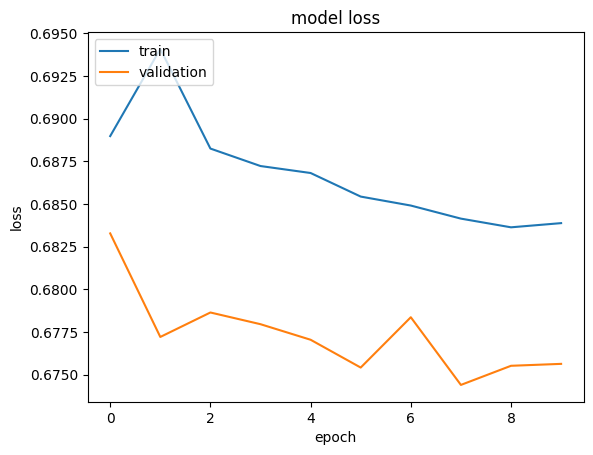

In [ ]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# plt.show()

In [ ]:
# import keras
# from keras import Model
# from keras.layers import Input, Dense, MultiHeadAttention, Bidirectional, Concatenate
# import keras.backend as K
# from keras import layers

# def create_LSTM_with_attention(hidden_units, dense_units):
#     x=Input(shape=(trainX.shape[1:]))
#     print("shape: ", x.shape)
#     conv_x = keras.layers.Conv1D(50, 5, activation='relu')(x)
#     print("shape: ", conv_x.shape)
#     conv_x = keras.layers.Conv1D(25, 5, activation='relu')(conv_x)
#     conv_att = layers.MultiHeadAttention(
#         key_dim=2, num_heads=5
#     )(conv_x, conv_x)
#     # reshaped_attention = keras.layers.Reshape((30,1), input_shape=(30,))(dropout_lstm)
#     batchnorm_reshaped_attention = keras.layers.BatchNormalization()(conv_att)
#     conv_x = keras.layers.Conv1D(25, 5, activation='relu')(batchnorm_reshaped_attention)
#     # lstm_layer = Bidirectional(LSTM(units=64, activation='tanh', return_sequences=True))(batchnorm_reshaped_attention)
#     lstm_layer = LSTM(50, return_sequences=False, activation='relu')(conv_x)
#     outputs=Dense(1, trainable=True, activation='sigmoid')(lstm_layer)
#     model=Model(x,outputs)
#     model.compile(loss='binary_crossentropy', optimizer='adam')
#     return model

# # Create the model with attention, train and evaluate
# model_attention = create_LSTM_with_attention(hidden_units=100, dense_units=1)

# model_attention.summary()

# model_attention.fit(trainX, trainY, epochs=10, batch_size=32, verbose=2, validation_split=0.2)

In [ ]:
df_combined_testing_scaled = scaler.transform(df_for_testing)
df_combined_testing_scaled = pd.DataFrame(df_combined_testing_scaled)

testX = []
testY = []
n_future = 1  # Number of days we want to predict into the future

n_past = 30
for i in range(n_past, len(df_combined_testing_scaled)):
     testX.append(df_combined_testing_scaled.iloc[i - n_past:i, 0:df_for_testing.shape[1]])
     testY.append(target_for_training.iloc[i-1])

testX, testY = np.array(testX), np.array(testY)
print(testX.shape, testY.shape)

(1958, 30, 8) (1958,)


62/62 [==============================] - 2s 14ms/step


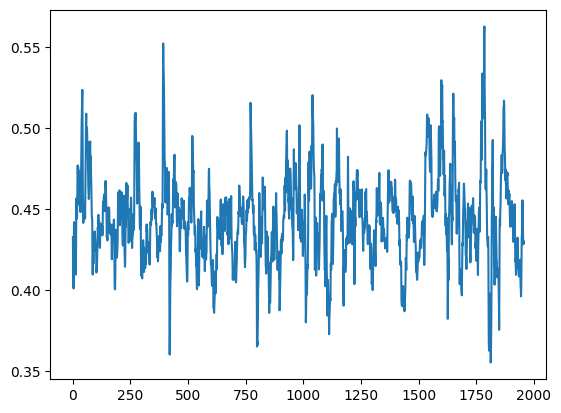

In [ ]:
import matplotlib.pyplot as plt

preds = model_attention.predict(testX)
plt1 = plt.plot(preds)

In [ ]:
new_preds = []
for i in range(0, len(preds)):
    if preds[i]>0.5:
      new_preds.append(1)
    else:
      new_preds.append(0)

In [ ]:
sum(testY)

777

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
print("Confusion Matrix: ")
print(confusion_matrix(new_preds, testY))
print("Accuracy score: ",accuracy_score(new_preds, testY))

Confusion Matrix: 
[[1144  744]
 [  37   33]]
Accuracy score:  0.601123595505618


In [ ]:
df

,Open,High,Low,Close,Adj Close,Volume,EWMA15,EWMA5,diff,target
Date,,,,,,,,,,
1980-02-04,0.010929,0.001799,0.003656,-0.003603,-0.003605,-0.203207,-0.001922,-0.002162,-0.360349,0
1980-02-05,-0.003603,0.000000,0.001821,0.007233,0.007234,0.323387,0.002097,0.002737,0.723317,0
1980-02-06,-0.001808,-0.008977,-0.014545,-0.017953,-0.005672,0.336654,-0.004405,-0.006220,-0.905804,0
1980-02-07,-0.010870,-0.010870,-0.009225,-0.018281,-0.018282,0.005885,-0.007267,-0.010338,-1.648348,0
1980-02-08,-0.016483,-0.009157,-0.013035,0.001862,0.001863,0.226404,-0.004395,-0.005457,0.186214,0
...,...,...,...,...,...,...,...,...,...,...
2019-07-08,0.001278,-0.001414,0.002573,-0.005729,-0.005729,0.122078,0.001780,0.000224,-0.340306,1
2019-07-09,-0.003119,-0.002123,-0.008127,-0.008821,-0.008821,0.404918,0.000438,-0.002792,-0.910319,1
2019-07-10,-0.004338,0.006525,0.004744,0.008182,0.008182,-0.252972,0.001409,0.000845,0.335710,1


In [ ]:
from sklearn.ensemble import RandomForestClassifier
X = df_combined
y = target_df

print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2,random_state =123)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

preds = clf.predict(X_test)


(9943, 8) (9943,)


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

print(confusion_matrix(preds, y_test))
print(accuracy_score(preds,y_test))

[[732 568]
 [337 352]]
0.5449974861739567


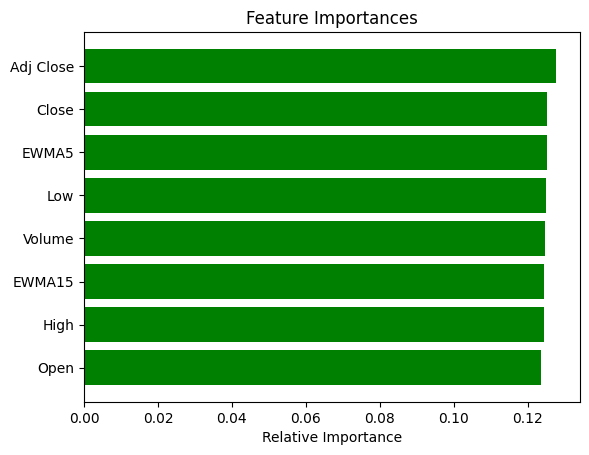

In [ ]:
importances = clf.feature_importances_
indices = np.argsort(importances)
features = df.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
pip install lazypredict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

X = df_combined
y = target_df

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2,random_state =123)

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

100%|██████████| 29/29 [00:58<00:00,  2.03s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LogisticRegression                 0.56               0.53     0.53      0.49   
RidgeClassifierCV                  0.56               0.53     0.53      0.49   
RidgeClassifier                    0.56               0.53     0.53      0.49   
LinearDiscriminantAnalysis         0.56               0.53     0.53      0.49   
LinearSVC                          0.56               0.53     0.53      0.49   
CalibratedClassifierCV             0.55               0.52     0.52      0.46   
NearestCentroid                    0.52               0.52     0.52      0.52   
BaggingClassifier                  0.53               0.52     0.52      0.52   
QuadraticDiscriminantAnalysis      0.54               0.52     0.52      0.49   
LGBMClassifier                     0.52               0.51     0.51      0.51   
AdaBoostClassifier          

In [ ]:
final_buffer_df = pd.merge(df_for_testing, df[['Open', 'Close']], left_index=True, right_index=True)
final_df = final_buffer_df[30:]
final_df.reset_index(drop = True, inplace = True)

In [ ]:
new_preds_df = pd.DataFrame(new_preds)
final_df['target'] = new_preds_df

In [ ]:
final_df

,Open_x,High,Low,Close_x,Volume,EWMA15,EWMA5,diff,Open_y,Close_y,target
0,0.01,0.00,-0.01,0.01,-0.10,0.01,0.01,-0.29,0.01,0.01,0
1,-0.02,-0.01,-0.00,-0.02,0.12,0.00,-0.00,-0.65,-0.02,-0.02,0
2,-0.01,-0.00,-0.01,-0.01,0.16,0.00,-0.00,-0.61,-0.01,-0.01,0
3,-0.02,-0.02,-0.02,0.01,0.02,0.00,-0.00,1.87,-0.02,0.01,0
4,0.02,0.01,0.02,0.01,-0.36,0.00,0.00,1.31,0.02,0.01,0
...,...,...,...,...,...,...,...,...,...,...,...
1953,0.00,-0.00,0.00,-0.01,0.12,0.00,0.00,-0.34,0.00,-0.01,0
1954,-0.00,-0.00,-0.01,-0.01,0.40,0.00,-0.00,-0.91,-0.00,-0.01,0
1955,-0.00,0.01,0.00,0.01,-0.25,0.00,0.00,0.34,-0.00,0.01,0
1956,0.01,-0.00,0.00,0.01,-0.15,0.00,0.00,0.32,0.01,0.01,0


In [ ]:
unique, counts = np.unique(testY, return_counts=True)
dict(zip(unique, counts))

{0: 1181, 1: 777}

In [ ]:
final_df['target'].value_counts()

0    1888
1      70
Name: target, dtype: int64

In [ ]:
profit = 0
loss = 0

for i in range(0, final_df.shape[0]-1):
    signal = final_df['target'][i]
    next_day_open = final_df['Open'][i+1]
    today_close = final_df['Close'][i]
    percent_change = (next_day_open- today_close)*100/today_close
    if signal == 0 and percent_change < 0:
      profit += abs(percent_change)
    elif signal == 0 and percent_change > 0:
      loss += abs(percent_change)
    elif signal ==1 and percent_change >0:
      profit += abs(percent_change)
    elif signal == 1 and percent_change <0:
      loss += abs(percent_change)


KeyError: ignored

In [ ]:
profit, loss

In [ ]:
final_df['target'].shape

In [ ]:
#Wrapper function to create all combinations
import math

final_df_shape = []
profit_arr = []
cf_matrix = []
acc_scores = []
def master_fn():
  df = pdr.get_data_yahoo("IBM", start="1980-02-01", end="2022-07-13")
  df_close = df
  df_close['EWMA15'] = df_close['Close'].ewm(span=5).mean()
  df_close['EWMA15_pct'] = df_close['EWMA15'].pct_change()*100
  df_close['RSI7'] = pta.rsi(df['Close'], length = 7)
  df_close['RSI7_pct'] = df_close['RSI7'].pct_change()*100
  df_close['diff'] = ((df_close['Close'] - df_close['Open'])/df_close['Open'])*100
  df_close['target'] = np.where(df_close['Open'].shift(-1)>df_close['Close'], 1, 0)
  df_close['Close_pct'] = df_close['Close'].pct_change()

  target_df = df_close['target']

  feature_list = [['diff', 'RSI7_pct', 'Close_pct'], ['diff', 'EWMA15_pct', 'Close_pct'], ['EWMA15_pct', 'RSI7_pct', 'Close_pct']]
  for count, features in enumerate(feature_list):
    print(count, features)
    buffer_df = df_close[features]
    df_combined = buffer_df[10:]
    target_df = target_df[10:]

    #Split the data

    training_data_len = math.ceil( len(df_combined) *.8)
    df_for_training = df_combined.iloc[:training_data_len,:]
    target_for_training = target_df.iloc[:training_data_len]
    df_for_testing = df_combined.iloc[training_data_len:,:]
    target_for_testing = target_df.iloc[training_data_len:]

    #Scale the data
    scaler = StandardScaler()
    scaler = scaler.fit(df_for_training)
    df_combined_training_scaled = scaler.transform(df_for_training)
    df_combined_training_scaled = pd.DataFrame(df_combined_training_scaled)
    trainX = []
    trainY = []
    n_future = 1  # Number of days we want to predict into the future

    n_past = 30
    for i in range(n_past, len(df_combined_training_scaled)):
        trainX.append(df_combined_training_scaled.iloc[i - n_past:i, 0:df_for_training.shape[1]])
        trainY.append(target_for_training.iloc[i])

    trainX, trainY = np.array(trainX), np.array(trainY)
    print(trainX.shape, trainY.shape)

    model_attention = create_LSTM_with_attention(hidden_units=100, dense_units=1)

    model_attention.fit(trainX, trainY, epochs=10, batch_size=32, verbose=2, validation_split=0.2)

    df_combined_testing_scaled = scaler.transform(df_for_testing)
    df_combined_testing_scaled = pd.DataFrame(df_combined_testing_scaled)

    testX = []
    testY = []
    n_future = 1  # Number of days we want to predict into the future

    n_past = 30
    for i in range(n_past, len(df_combined_testing_scaled)):
        testX.append(df_combined_testing_scaled.iloc[i - n_past:i, 0:df_for_testing.shape[1]])
        testY.append(target_for_training.iloc[i])

    testX, testY = np.array(testX), np.array(testY)
    print(testX.shape, testY.shape)

    preds = model_attention.predict(testX)

    new_preds = []
    for i in range(0, len(preds)):
        if preds[i]>0.5:
          new_preds.append(1)
        else:
          new_preds.append(0)

    acc_scores.append(accuracy_score(new_preds, testY))
    cf_matrix.append(confusion_matrix(new_preds, testY))
    print(confusion_matrix(new_preds, testY))
    print(accuracy_score(new_preds, testY))
    final_buffer_df = pd.merge(df_for_testing, df_close[['Open', 'Close']], left_index=True, right_index=True)
    final_df = final_buffer_df[30:]
    final_df.reset_index(drop = True, inplace = True)

    new_preds_df = pd.DataFrame(new_preds)
    final_df['target'] = new_preds_df
    profit = 0
    loss = 0

    for i in range(0, final_df.shape[0]-1):
        signal = final_df['target'][i]
        next_day_open = final_df['Open'][i+1]
        today_close = final_df['Close'][i]
        percent_change = (next_day_open- today_close)*100/today_close
        if signal == 0 and percent_change < 0:
          profit += abs(percent_change)
        elif signal == 0 and percent_change > 0:
          loss += abs(percent_change)
        elif signal ==1 and percent_change >0:
          profit += abs(percent_change)
        elif signal == 1 and percent_change <0:
          loss += abs(percent_change)
    print("profit is: ", profit-loss)
    profit_arr.append(profit-loss)

master_fn()

In [ ]:
for i in cf_matrix:
  print(i)

In [ ]:
final_df